# API & LangGraph


## 0. 환경 설정

In [5]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [6]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("API-LangGraph-Test")

LangSmith 추적을 시작합니다.
[프로젝트명]
API-LangGraph-Test


## 1. State 정의

In [7]:
from typing import Annotated, TypedDict, Any
from langgraph.graph.message import add_messages

# .env에 정의된 API 사용 여부를 고려해 상태를 확장합니다.
class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # 입력 질문

    openai_answer: Annotated[str | None, "OpenAI 응답"]
    gemini_answer: Annotated[str | None, "Google Gemini 응답"]
    anthropic_answer: Annotated[str | None, "Anthropic Claude 응답"]
    upstage_answer: Annotated[str | None, "Upstage 응답"]
    perplexity_answer: Annotated[str | None, "Perplexity 응답"]
    huggingface_answer: Annotated[str | None, "HuggingFace 응답"] 
    tavily_search: Annotated[str | None, "Tavily 검색 결과"]

    answer: Annotated[dict[str, Any] | None, "최종 답변"]

    api_status: Annotated[dict[str, Any] | None, "API별 호출 메타데이터"]

    openai_status: Annotated[dict[str, Any] | None, "OpenAI 호출 상태"]
    gemini_status: Annotated[dict[str, Any] | None, "Gemini 호출 상태"]
    anthropic_status: Annotated[dict[str, Any] | None, "Anthropic 호출 상태"]
    upstage_status: Annotated[dict[str, Any] | None, "Upstage 호출 상태"]
    perplexity_status: Annotated[dict[str, Any] | None, "Perplexity 호출 상태"]
    huggingface_status: Annotated[dict[str, Any] | None, "HuggingFace 호출 상태"]
    
    messages: Annotated[list, add_messages]  # 메시지 기록


In [8]:
from collections.abc import Mapping


def build_status_from_response(response: Any, default_status: int = 200, detail: str = "success") -> dict[str, Any]:
    """LLM 응답 객체에서 상태 정보를 추출합니다."""
    metadata: Mapping[str, Any] | None = getattr(response, "response_metadata", None)
    metadata = metadata or {}
    status = metadata.get("status_code") or metadata.get("status") or metadata.get("http_status")
    detail_text = metadata.get("finish_reason") or metadata.get("reason") or detail
    return {"status": status or default_status, "detail": detail_text}


def build_status_from_error(error: Exception) -> dict[str, Any]:
    """예외 객체에서 상태 코드를 유추합니다."""
    status = getattr(error, "status_code", None)
    if status is None:
        response = getattr(error, "response", None)
        if response is not None:
            status = getattr(response, "status_code", None)
    return {"status": status or "error", "detail": str(error)}


def format_response_message(label: str, payload: Any) -> tuple[str, str]:
    """메시지 로그에 기록할 튜플을 생성합니다."""
    return ("assistant", f"[{label}] {payload}")


## 2. 노드(Node) 정의

In [9]:
def init_question(state: GraphState) -> GraphState:
    """그래프 시작 시 질문을 검증하고 기본 상태를 세팅합니다."""
    question = state.get("question")
    if not question:
        raise ValueError("질문이 비어 있습니다.")

    return GraphState(
        question=question,
        messages=[("user", question)],
        api_status={},
    )


In [10]:
from langchain_openai import ChatOpenAI


def call_openai(state: GraphState) -> GraphState:
    question = state["question"]

    llm = ChatOpenAI(
        model="gpt-5-nano"
    )
    try:
        response = llm.invoke(question)
        content = response.content if hasattr(response, "content") else str(response)
        status = build_status_from_response(response)
        return GraphState(
            openai_answer=content,
            openai_status=status,
            messages=[format_response_message("OpenAI", response)],
        )
    except Exception as exc:
        status = build_status_from_error(exc)
        return GraphState(
            openai_status=status,
            messages=[format_response_message("OpenAI 오류", exc)],
        )


In [11]:
from langchain_google_genai import ChatGoogleGenerativeAI


def call_gemini(state: GraphState) -> GraphState:
    question = state["question"]

    llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash-lite",
        temperature=0,
    )
    try:
        response = llm.invoke(question)
        content = response.content if hasattr(response, "content") else str(response)
        status = build_status_from_response(response)
        return GraphState(
            gemini_answer=content,
            gemini_status=status,
            messages=[format_response_message("Gemini", response)],
        )
    except Exception as exc:
        status = build_status_from_error(exc)
        return GraphState(
            gemini_status=status,
            messages=[format_response_message("Gemini 오류", exc)],
        )


In [12]:
from langchain_anthropic import ChatAnthropic


def call_anthropic(state: GraphState) -> GraphState:
    question = state["question"]

    llm = ChatAnthropic(
        model="claude-haiku-4-5-20251001",
        temperature=0,
    )
    try:
        response = llm.invoke(question)
        content = response.content if hasattr(response, "content") else str(response)
        status = build_status_from_response(response)
        return GraphState(
            anthropic_answer=content,
            anthropic_status=status,
            messages=[format_response_message("Anthropic", response)],
        )
    except Exception as exc:
        status = build_status_from_error(exc)
        return GraphState(
            anthropic_status=status,
            messages=[format_response_message("Anthropic 오류", exc)],
        )


In [13]:
from langchain_upstage import ChatUpstage


def call_upstage(state: GraphState) -> GraphState:
    question = state["question"]

    llm = ChatUpstage(
        model="solar-mini",
    )
    try:
        response = llm.invoke(question)
        content = response.content if hasattr(response, "content") else str(response)
        status = build_status_from_response(response)
        return GraphState(
            upstage_answer=content,
            upstage_status=status,
            messages=[format_response_message("Upstage", response)],
        )
    except Exception as exc:
        status = build_status_from_error(exc)
        return GraphState(
            upstage_status=status,
            messages=[format_response_message("Upstage 오류", exc)],
        )


In [14]:
from langchain_teddynote.models import ChatPerplexity


def call_perplexity(state: GraphState) -> GraphState:
    question = state["question"]

    llm = ChatPerplexity(
        model="sonar",
        temperature=0.2,
        top_p=0.9,
        search_domain_filter=["perplexity.ai"],
        return_images=False,
        return_related_questions=True,
        # search_recency_filter="month",
        top_k=0,
        stream=False,
    )

    try:
        response = llm.invoke(question)
        content = response.content if hasattr(response, "content") else str(response)
        status = build_status_from_response(response)
        return GraphState(
            perplexity_answer=content,
            perplexity_status=status,
            messages=[format_response_message("Perplexity", response)],
        )
    except Exception as exc:
        status = build_status_from_error(exc)
        return GraphState(
            perplexity_status=status,
            messages=[format_response_message("Perplexity 오류", exc)],
        )


In [21]:
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint

def call_huggingface(state: GraphState) -> GraphState:
    question = state["question"]

    llm = HuggingFaceEndpoint(
        repo_id="Qwen/Qwen2.5-72B-Instruct",     
        task="text-generation",
        max_new_tokens=512,
        do_sample=False,
        repetition_penalty=1.03,
    )

    chat_model = ChatHuggingFace(llm=llm)        

    try:
        response = chat_model.invoke(question)
        content = response.content if hasattr(response, "content") else str(response)
        status = build_status_from_response(response)
        return GraphState(
            huggingface_answer=content,
            huggingface_status=status,
            messages=[format_response_message("HuggingFace", response)],
        )
    except Exception as exc:
        status = build_status_from_error(exc)    
        return GraphState(
            huggingface_status=status,
            messages=[format_response_message("HuggingFace 오류", exc)],
        )

In [16]:
# from langchain_teddynote.tools.tavily import TavilySearch

# def call_tavily(state: GraphState) -> GraphState:
#     question = state["question"]

#     tavily_tool = TavilySearch()
#     response = tavily_tool.search(
    #     query=question,  # 검색 쿼리
    #     topic="news",  # 일반 주제
    #     days=1,  # 최근 1일 내 검색
    #     max_results=3,  # 최대 검색 결과
    #     format_output=True,  # 결과 포맷팅
    # )

#     return GraphState(tavily_search=response)


In [22]:
LLM_FIELDS = [
    ("openai_answer", "OpenAI", "openai_status"),
    ("gemini_answer", "Gemini", "gemini_status"),
    ("anthropic_answer", "Anthropic", "anthropic_status"),
    ("perplexity_answer", "Perplexity", "perplexity_status"),
    ("upstage_answer", "Upstage", "upstage_status"),
    ("huggingface_answer", "HuggingFace", "huggingface_status"),
    # ("tavily_search", "Tavily Search", None),
]


def summarize_answers(state: GraphState) -> GraphState:
    """노드별 응답을 모아 최종 답변과 상태 요약을 생성합니다."""
    answers: dict[str, Any] = {}
    api_status: dict[str, Any] = {}

    for answer_key, label, status_key in LLM_FIELDS:
        answers[label] = state.get(answer_key)
        if status_key is not None:
            status_value = state.get(status_key)
            if status_value is not None:
                api_status[label] = status_value

    return GraphState(
        answer=answers,
        api_status=api_status,
    )


## 3. 그래프 생성

In [23]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("init_question", init_question)
workflow.add_node("call_openai", call_openai)
workflow.add_node("call_gemini", call_gemini)
workflow.add_node("call_anthropic", call_anthropic)
workflow.add_node("call_upstage", call_upstage)
workflow.add_node("call_perplexity", call_perplexity)
workflow.add_node("call_huggingface", call_huggingface)
workflow.add_node("summarize_answers", summarize_answers)

# 엣지 정의
workflow.add_edge("init_question", "call_openai")
workflow.add_edge("init_question", "call_gemini")
workflow.add_edge("init_question", "call_anthropic")
workflow.add_edge("init_question", "call_upstage")
workflow.add_edge("init_question", "call_perplexity")
workflow.add_edge("init_question", "call_huggingface")

workflow.add_edge("call_openai", "summarize_answers")
workflow.add_edge("call_gemini", "summarize_answers")
workflow.add_edge("call_anthropic", "summarize_answers")
workflow.add_edge("call_upstage", "summarize_answers")
workflow.add_edge("call_perplexity", "summarize_answers")
workflow.add_edge("call_huggingface", "summarize_answers")
workflow.add_edge("summarize_answers", END)  # 답변 -> 종료

# 그래프 진입점 설정
workflow.set_entry_point("init_question")

# 체크포인터 설정
memory = MemorySaver()

# 컴파일
app = workflow.compile(checkpointer=memory)

컴파일한 그래프를 시각화 합니다.

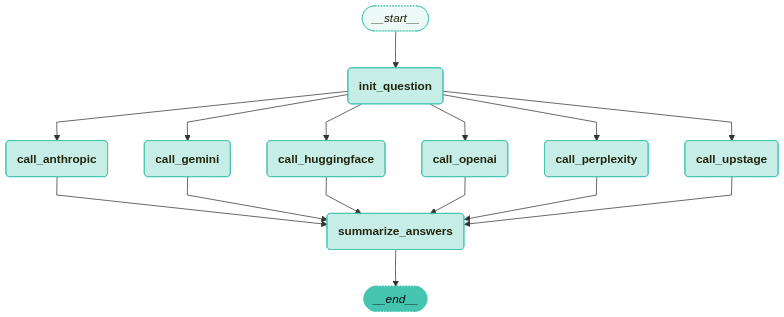

In [24]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

## 4. 그래프 실행

- `config` 파라미터는 그래프 실행 시 필요한 설정 정보를 전달합니다.
- `recursion_limit`: 그래프 실행 시 재귀 최대 횟수를 설정합니다.
- `inputs`: 그래프 실행 시 필요한 입력 정보를 전달합니다.

In [25]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question="너의 특징은 무엇이고 장점은 뭐지?")

# 그래프 실행
invoke_graph(app, inputs, config)


🔄 Node: init_question 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
question:
너의 특징은 무엇이고 장점은 뭐지?
('user', '너의 특징은 무엇이고 장점은 뭐지?')
question:
너의 특징은 무엇이고 장점은 뭐지?
messages:
[('user', '너의 특징은 무엇이고 장점은 뭐지?')]
api_status:
{}

🔄 Node: call_huggingface 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
huggingface_status:
{'status': 403, 'detail': '(Request ID: Root=1-691d3299-6ef4465c03e22ac67abb1ce6;64d7b6ae-0814-48fa-947e-cabfdb9e0f18)\n\n403 Forbidden: This authentication method does not have sufficient permissions to call Inference Providers on behalf of user YS-2357.\nCannot access content at: https://router.huggingface.co/novita/v3/openai/chat/completions.\nMake sure your token has the correct permissions.'}
messages:
[('assistant', '[HuggingFace 오류] (Request ID: Root=1-691d3299-6ef4465c03e22ac67abb1ce6;64d7b6ae-0814-48fa-947e-cabfdb9e0f18)\n\n403 Forbidden: This authentication method does not have sufficient permissions to call Inference Providers on behalf of user YS-2357.\n

In [26]:
# 그래프를 스트리밍 출력
# stream_graph(app, inputs, config)

In [27]:
outputs = app.get_state(config).values

print(f"Question: {outputs['question']}")
print("===" * 20)

print("Answers by model:")
for model, answer in (outputs.get("answer") or {}).items():
    display_answer = answer if answer is not None else "응답 없음"
    print(f"- {model}: {display_answer}")

print("===" * 20)
print("API status:")
for model, status in (outputs.get("api_status") or {}).items():
    code = status.get("status") if isinstance(status, dict) else status
    detail = status.get("detail") if isinstance(status, dict) else ""
    detail_text = f" ({detail})" if detail else ""
    print(f"- {model}: {code}{detail_text}")

print("===" * 20)
print("Messages:")
for message in outputs.get("messages", []):
    if isinstance(message, tuple) and len(message) == 2:
        role, content = message
        print(f"{role}: {content}")
    else:
        print(message)


Question: 너의 특징은 무엇이고 장점은 뭐지?
Answers by model:
- OpenAI: 다음은 제 특징과 장점에 대한 간단한 소개예요.

주요 특징
- 자연스러운 대화와 맥락 이해: 전에 무슨 대화를 했는지 기억하고 흐름에 맞춰 응답해요(현재 세션 안에서만 맥락 유지).
- 다양한 작업 지원: 요약, 설명, 비교, 글쓰기, 번역, 아이디어 생성, 노트 정리 등 여러 가지를 도와드려요.
- 창의적이고 실용적인 도움: 브레인스토밍, 스토리 아이디어, 마크다운 문서 구성, 체크리스트 작성 등 창의적 지원이 가능해요.
- 코딩 및 기술 도움: 코드 예제 작성, 디버깅 아이디어 제시, 알고리즘 설명 등을 제공해요.
- 다국어 소통: 한국어를 포함한 여러 언어로 의사소통하고 도움을 줄 수 있어요.
- 톤과 형식 맞춤: 원하시는 말투(간단/친절/전문/공손 등)와 출력 형식으로 맞춰 드려요.
- 안전하고 책임 있는 응답: 부적절하거나 위험한 행위에 대해서는 경고하고 대체 방법을 제시해요.

장점
- 시간 절약: 빠른 답변으로 학습·작업 속도를 높여줘요.
- 다양한 포맷 지원: 요약문, 목록, 비교표, 코드 블록, 예시 텍스트 등 다양한 형식으로 출력 가능해요.
- 문제 해결 능력: 수학, 논리 문제, 분석적 사고가 필요한 질문에 대해 합리적인 접근을 제시해요.
- 학습 도구로 활용 가능: 설명을 이해하기 쉽게 풀어주고, 연습 문제나 예제까지 제공해요.
- 일상과 업무의 연결성: 메모 작성, 이메일 초안, 발표 슬라이드 아이디어 등 실무적 도움도 돕습니다.

참고 및 한계
- 최신 정보 여부: 제 지식은 2024년까지의 정보에 기반해요. 최신 뉴스나 실시간 정보가 필요하면 스스로 확인해 주세요.
- 정확성의 한계: 때로는 부정확한 부분이 있을 수 있어요. 중요한 판단은 반드시 추가 확인을 부탁드립니다.
- 전문 분야 교차 확인 필요성: 의료, 법률, 재무 등 민감한 분야는 전문가와 교차 검토가 좋습니다.
- 프라이버시: 현재 세션에서의 대화 맥락을 바탕으로 답

In [28]:
outputs

{'question': '너의 특징은 무엇이고 장점은 뭐지?',
 'openai_answer': '다음은 제 특징과 장점에 대한 간단한 소개예요.\n\n주요 특징\n- 자연스러운 대화와 맥락 이해: 전에 무슨 대화를 했는지 기억하고 흐름에 맞춰 응답해요(현재 세션 안에서만 맥락 유지).\n- 다양한 작업 지원: 요약, 설명, 비교, 글쓰기, 번역, 아이디어 생성, 노트 정리 등 여러 가지를 도와드려요.\n- 창의적이고 실용적인 도움: 브레인스토밍, 스토리 아이디어, 마크다운 문서 구성, 체크리스트 작성 등 창의적 지원이 가능해요.\n- 코딩 및 기술 도움: 코드 예제 작성, 디버깅 아이디어 제시, 알고리즘 설명 등을 제공해요.\n- 다국어 소통: 한국어를 포함한 여러 언어로 의사소통하고 도움을 줄 수 있어요.\n- 톤과 형식 맞춤: 원하시는 말투(간단/친절/전문/공손 등)와 출력 형식으로 맞춰 드려요.\n- 안전하고 책임 있는 응답: 부적절하거나 위험한 행위에 대해서는 경고하고 대체 방법을 제시해요.\n\n장점\n- 시간 절약: 빠른 답변으로 학습·작업 속도를 높여줘요.\n- 다양한 포맷 지원: 요약문, 목록, 비교표, 코드 블록, 예시 텍스트 등 다양한 형식으로 출력 가능해요.\n- 문제 해결 능력: 수학, 논리 문제, 분석적 사고가 필요한 질문에 대해 합리적인 접근을 제시해요.\n- 학습 도구로 활용 가능: 설명을 이해하기 쉽게 풀어주고, 연습 문제나 예제까지 제공해요.\n- 일상과 업무의 연결성: 메모 작성, 이메일 초안, 발표 슬라이드 아이디어 등 실무적 도움도 돕습니다.\n\n참고 및 한계\n- 최신 정보 여부: 제 지식은 2024년까지의 정보에 기반해요. 최신 뉴스나 실시간 정보가 필요하면 스스로 확인해 주세요.\n- 정확성의 한계: 때로는 부정확한 부분이 있을 수 있어요. 중요한 판단은 반드시 추가 확인을 부탁드립니다.\n- 전문 분야 교차 확인 필요성: 의료, 법률, 재무 등 민감한 분야는 전문가와 교차 검토가 좋습니다.\n- 프라이버시: 현재 

: 

: 

: 